**Simple Character-Level RNN for Text Generation**

Learning objective: Understand RNN architecture and training loop

Below is the architecture of **Multilayer RNN**

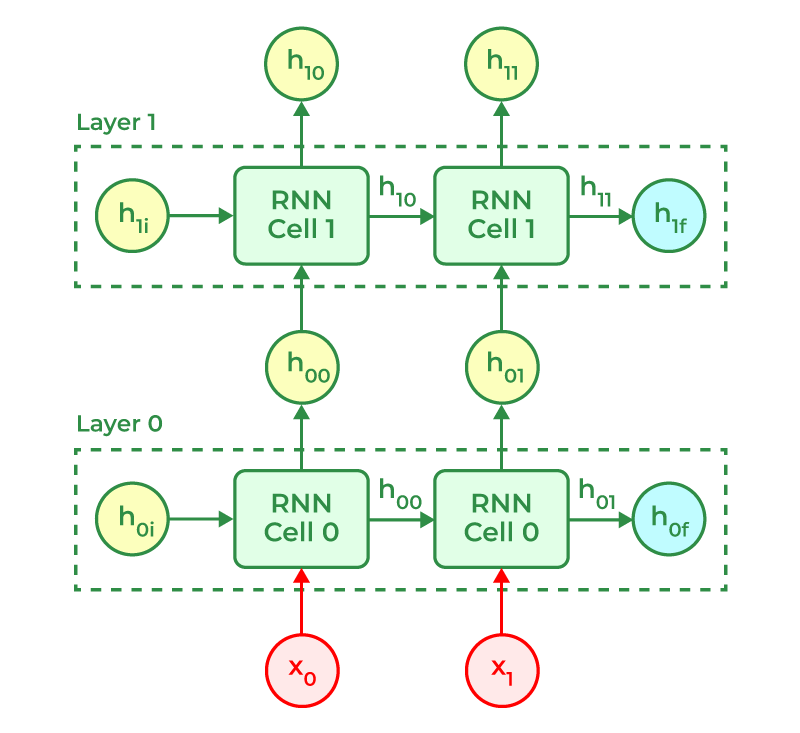

In [72]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [73]:
# Hyperparameters
HIDDEN_SIZE = 128
NUM_LAYERS = 2
LEARNING_RATE = 0.003
NUM_EPOCHS = 100
SEQ_LENGTH = 100

In [86]:
len(text)  - (3595 * 32)

104

In [74]:
class CharRNN(nn.Module):
    """
    Simple RNN for character-level text generation
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer: output only the hidden state (h), calculate. It doesn't apply the softmax function, nor does the hidden x output layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        """
        Forward pass
        x: (batch, seq_len, input_size)
        hidden: (num_layers, batch, hidden_size)
        """
        out, hidden = self.rnn(x, hidden)
        # out: (batch, seq_len, hidden_size)

        # Reshape for FC layer
        out = out.reshape(-1, self.hidden_size)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)


In [75]:
class TextDataset(Dataset):
    """Dataset for character-level text"""
    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length
        self.chars = sorted(list(set(text)))  # extracting characters only (A-Z).
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}  # creating a dictionary/ vocabolary out of it.
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        """
        Returns input sequence and target (next character)
        """
        seq = self.text[idx:idx+self.seq_length]
        target = self.text[idx+1:idx+self.seq_length+1]

        # Convert to indices
        seq_idx = [self.char_to_idx[ch] for ch in seq]
        target_idx = [self.char_to_idx[ch] for ch in target]

        return torch.tensor(seq_idx), torch.tensor(target_idx)


In [76]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [77]:
dataset = TextDataset(text, SEQ_LENGTH)  # return pair of  (in_seq, target_seq).
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  #  returns 32 {batch_size} x pairs of (in,out)

In [78]:
model = CharRNN(
        input_size=dataset.vocab_size,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        output_size=dataset.vocab_size
    )

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [80]:
def generate_text(model, dataset, start_str="The ", length=100):
    """Generate text using trained model"""
    model.eval()

    chars = [ch for ch in start_str]
    hidden = model.init_hidden(1)

    with torch.no_grad():
        for i in range(length):
            # Encode current sequence
            seq_idx = [dataset.char_to_idx[ch] for ch in chars[-SEQ_LENGTH:]]
            seq_tensor = torch.tensor([seq_idx])
            seq_onehot = torch.nn.functional.one_hot(
                seq_tensor,
                num_classes=dataset.vocab_size
            ).float()

            # Predict next character
            output, hidden = model(seq_onehot, hidden)

            # Sample from output distribution
            prob = torch.nn.functional.softmax(output[-1], dim=0)
            next_char_idx = torch.multinomial(prob, 1).item()
            next_char = dataset.idx_to_char[next_char_idx]

            chars.append(next_char)

    return ''.join(chars)

In [81]:
model.train()
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    hidden = model.init_hidden(32)

    for batch_idx, (sequences, targets) in enumerate(dataloader):
        #print(sequences.shape)
        # One-hot encode input
        sequences_onehot = torch.nn.functional.one_hot(
            sequences, 
            num_classes=dataset.vocab_size
        ).float()
        #print(sequences_onehot.shape)

        # Forward pass
        outputs, hidden = model(sequences_onehot, hidden.detach())
        loss = criterion(outputs, targets.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')

        # Generate sample
        #sample = generate_text(model, dataset, start_str="The ", length=200)
        #print(f'Generated: {sample}\n')

torch.save(model.state_dict(), 'char_rnn_model.pth')


KeyboardInterrupt: 

In [ ]:




def train():
    """Training loop"""
    # Load your text file (use any text - Shakespeare, book, etc.)
    with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()

    # Create dataset
    dataset = TextDataset(text, SEQ_LENGTH)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Model
    model = CharRNN(
        input_size=dataset.vocab_size,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        output_size=dataset.vocab_size
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training
    model.train()
    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        hidden = model.init_hidden(32)

        for batch_idx, (sequences, targets) in enumerate(dataloader):
            # One-hot encode input
            sequences_onehot = torch.nn.functional.one_hot(
                sequences, 
                num_classes=dataset.vocab_size
            ).float()

            # Forward pass
            outputs, hidden = model(sequences_onehot, hidden.detach())
            loss = criterion(outputs, targets.view(-1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)  # Gradient clipping
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / len(dataloader)
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')

            # Generate sample
            sample = generate_text(model, dataset, start_str="The ", length=200)
            print(f'Generated: {sample}\n')

    # Save model
    torch.save(model.state_dict(), 'char_rnn_model.pth')
    return model, dataset


def generate_text(model, dataset, start_str="The ", length=100):
    """Generate text using trained model"""
    model.eval()

    chars = [ch for ch in start_str]
    hidden = model.init_hidden(1)

    with torch.no_grad():
        for i in range(length):
            # Encode current sequence
            seq_idx = [dataset.char_to_idx[ch] for ch in chars[-SEQ_LENGTH:]]
            seq_tensor = torch.tensor([seq_idx])
            seq_onehot = torch.nn.functional.one_hot(
                seq_tensor,
                num_classes=dataset.vocab_size
            ).float()

            # Predict next character
            output, hidden = model(seq_onehot, hidden)

            # Sample from output distribution
            prob = torch.nn.functional.softmax(output[-1], dim=0)
            next_char_idx = torch.multinomial(prob, 1).item()
            next_char = dataset.idx_to_char[next_char_idx]

            chars.append(next_char)

    return ''.join(chars)


if __name__ == "__main__":
    model, dataset = train()

    # Generate samples
    print("\n=== Final Generation ===")
    for start in ["The ", "In ", "When "]:
        sample = generate_text(model, dataset, start_str=start, length=300)
        print(f'\nStarting with "{start}":\n{sample}\n')